In [1]:
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#import data
features = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/DFT_features/all_dft_features.csv')
labels = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Data/boronic_acid_with_products.csv', usecols=['Yield /%'])
features_and_labels = pd.concat([features, labels], axis=1)


In [3]:
corr_matrix = features_and_labels.corr()
corr_matrix['Yield /%'].sort_values(ascending=False)

Yield /%                1.000000
catalyst_L_1            0.196620
catalyst_B5_3           0.180290
catalyst_L_2            0.161344
amine_B5_1              0.103821
acid_homo_lumo          0.086028
product_dipole          0.084412
amine_homo_lumo         0.075246
acid_amine_gap          0.074274
acid_single_point       0.071954
amine_B1_2              0.059057
delta_g_reaction        0.056604
product_homo_lumo       0.048373
product_single_point    0.047039
acid_L                  0.045159
amine_B1_1              0.036731
amine_L_1               0.036544
amine_dipole            0.036452
amine_B1_3              0.016037
amine_single_point      0.013710
acid_B1                 0.011655
amine_B5_3              0.008323
amine_L_2               0.003271
acid_B5                -0.003716
amine_B5_2             -0.014369
acid_dipole            -0.071009
catalyst_B5_2          -0.072031
amine_L_3              -0.075814
catalyst_L_3           -0.108854
catalyst_B1_2          -0.161290
catalyst_B

In [4]:
#Stratify by Boron Partial Charge as before
features_and_labels['boron_charge_cat'] = pd.cut(features_and_labels['boron_partial_charge'], bins=[0, 0.3, 0.43, 0.47, 0.5, np.inf], labels=[1, 2, 3,4, 5])


In [5]:
#Generate training and test sets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features_and_labels, features_and_labels['boron_charge_cat']):
  strat_train_set = features_and_labels.loc[train_index]
  strat_test_set = features_and_labels.loc[test_index]

In [6]:
#Remove the boron charge category labels from the data

for set_ in (strat_train_set, strat_test_set):
  set_.drop('boron_charge_cat', axis=1, inplace=True)

In [7]:
#Separate labels and features in training set

training_features_unscaled = strat_train_set.drop('Yield /%', axis=1)
training_labels_unscaled = strat_train_set['Yield /%'].copy()
training_labels_unscaled.to_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/training_labels_unscaled.csv', index=True)

In [8]:
#Standardise the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(training_features_unscaled)
train_features.shape


(238, 33)

In [9]:
#Convert back to Pandas Dataframe
column_titles = list(training_features_unscaled.columns.values)
row_titles = list(training_features_unscaled.index)
train_features = pd.DataFrame(train_features, columns=column_titles, index=row_titles)
train_features
train_features.to_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/dft_training_features.csv', index=True)

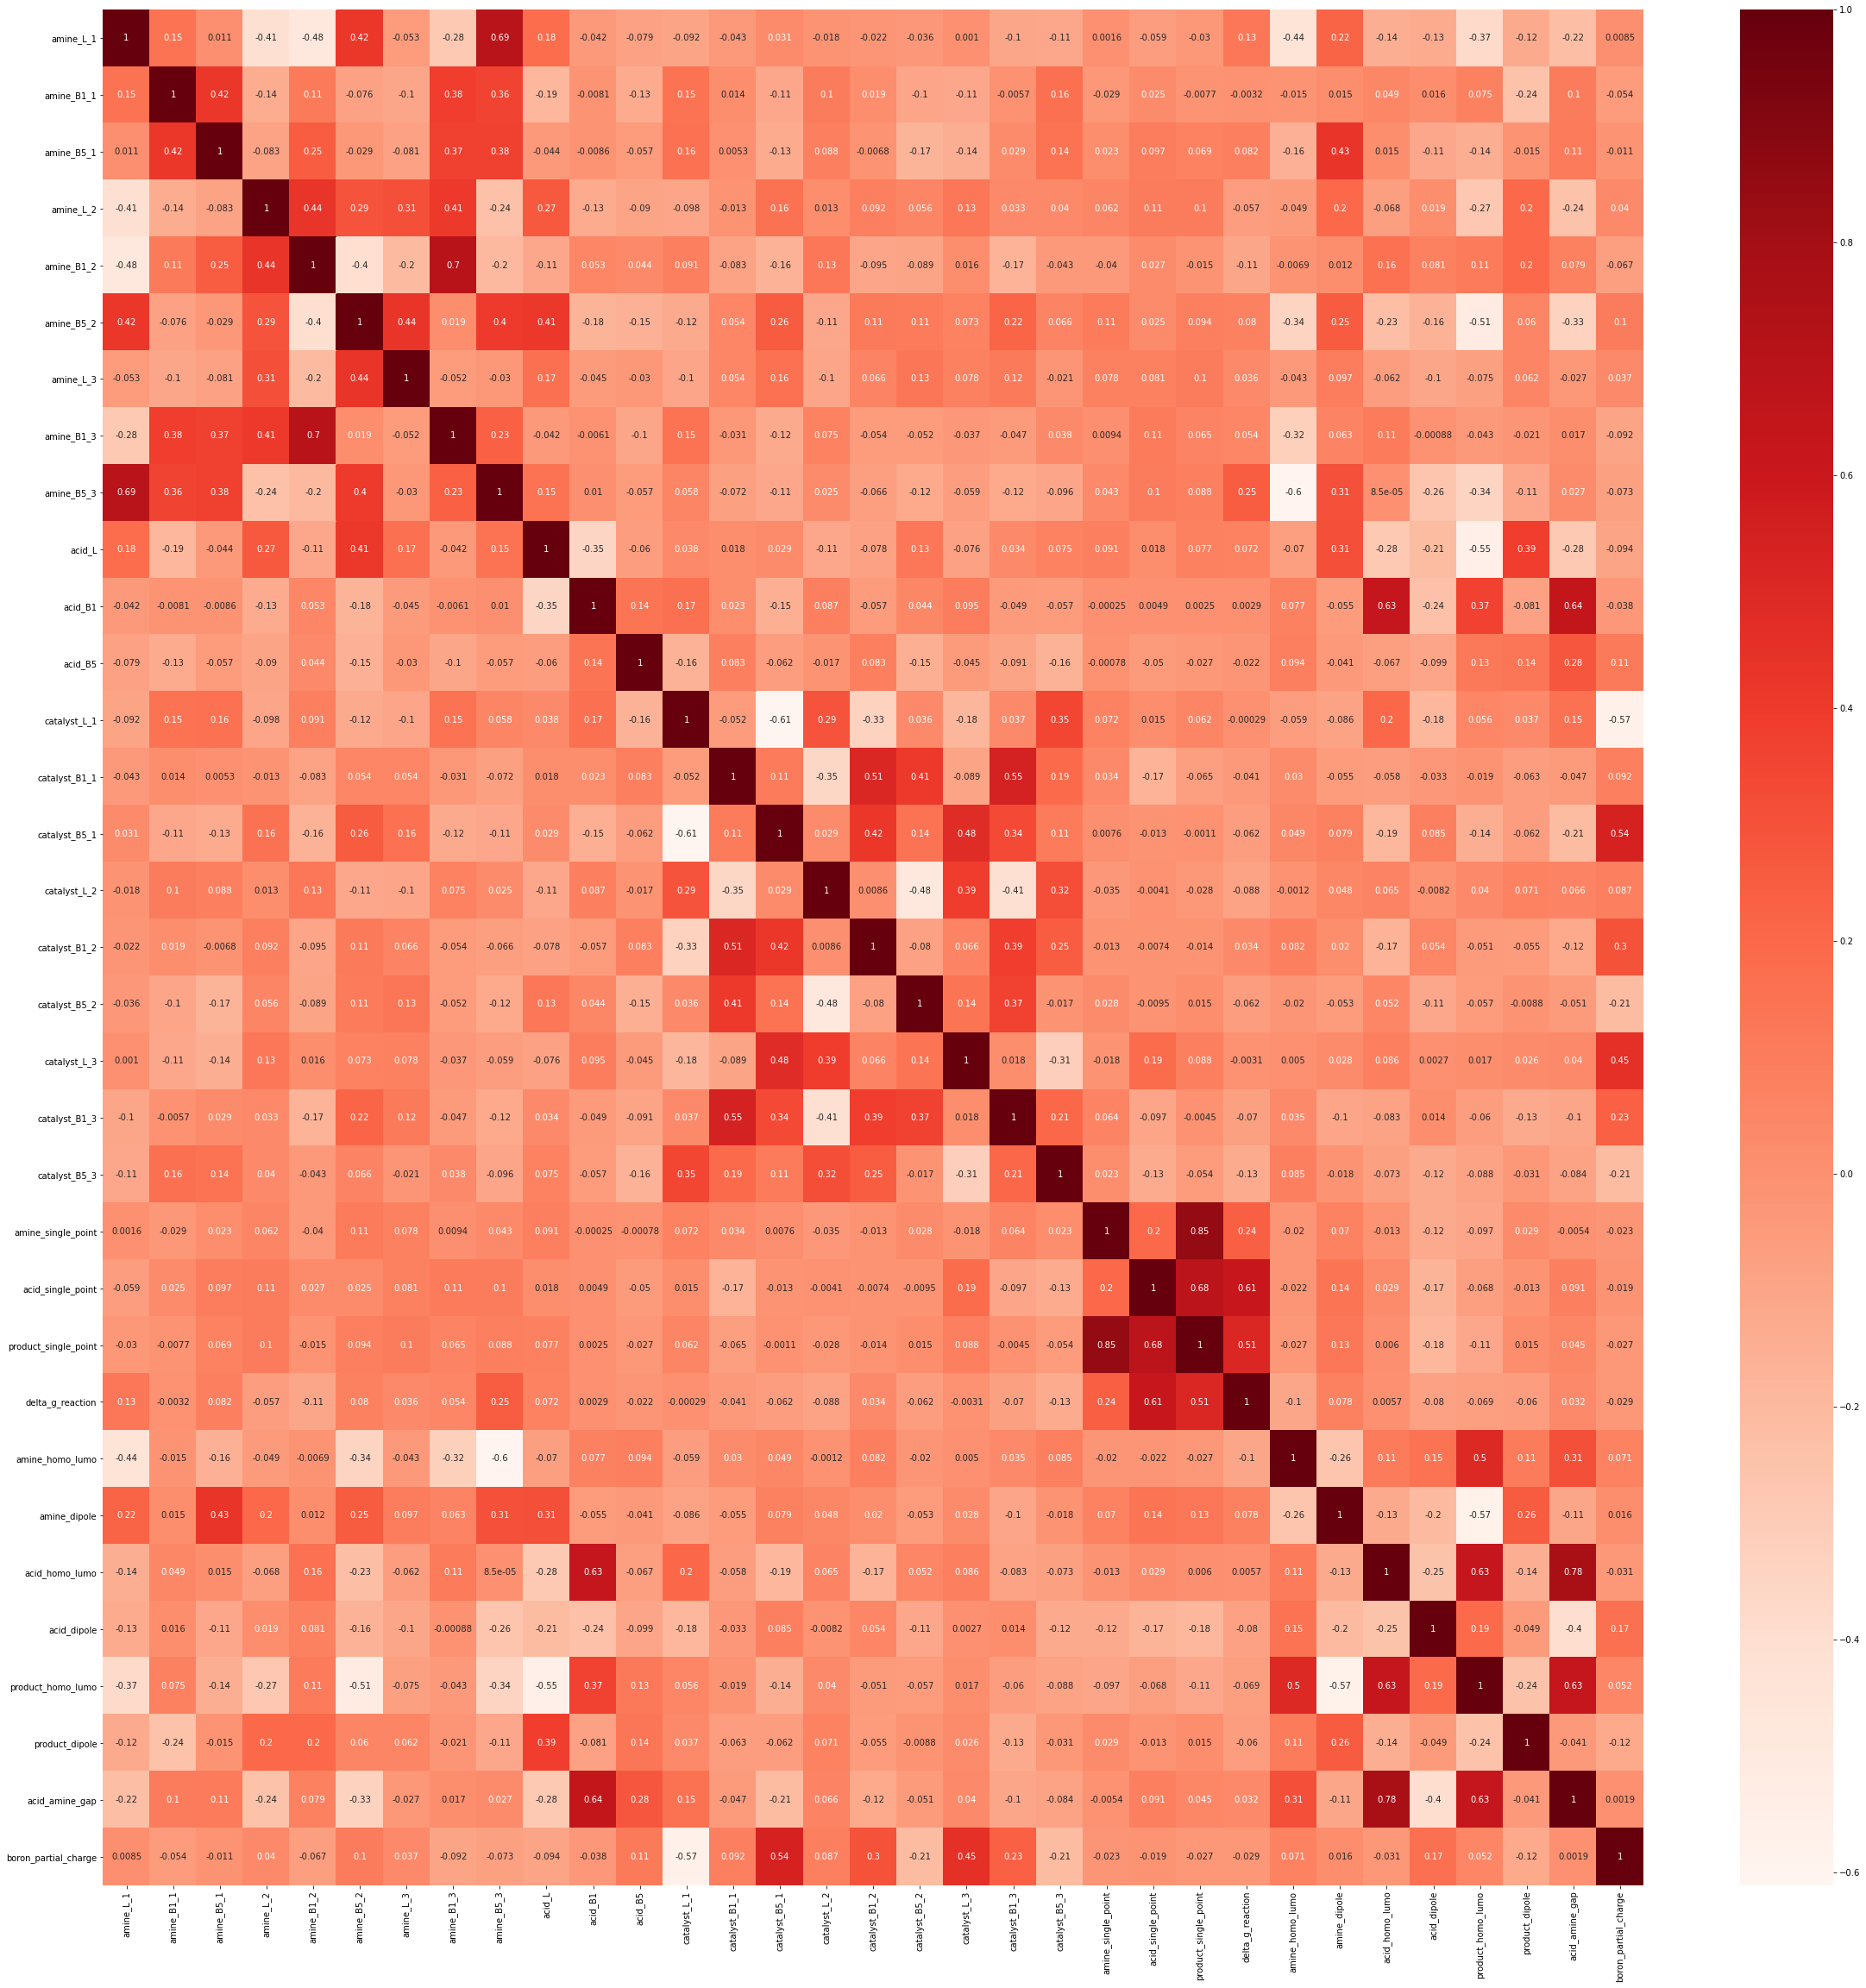

In [10]:
import seaborn as sns

plt.figure(figsize=(40,40))
cor = train_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
def display_scores(scores):
  print('Scores', scores)
  print('Mean', scores.mean())
  print('Standard Deviation', scores.std())

In [12]:
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.neural_network import MLPRegressor



In [13]:
models = {
    'Ridge Regression' : Ridge(),
    'Decision Tree': DecisionTreeRegressor(), 
    'Random Forest': RandomForestRegressor(),
    'Elastic Net': ElasticNet(),
    'Linear SVM': SVR(kernel='linear', C=0.1),
    'RBF SVM': SVR(kernel='rbf', C=0.1),
    'Quadratic SVM': SVR(kernel='poly', degree=2, C=0.1),
    'Cubic SVM': SVR(kernel='poly', degree=3, C=0.1),
    'Quartic SVM': SVR(kernel='poly', degree =4, C=0.1),
    #'Quintic SVM': SVR(kernel='poly', degree=5, C=0.1),
    'kNN': KNeighborsRegressor(),
    'GBoost': GradientBoostingRegressor(),
    'MLPerceptron': MLPRegressor(max_iter=500)
}

def run_models(models, training_features, training_labels):
    r2_scores = {}
    rmse_scores = {}
    predicted={}
    for key, regressor in models.items():
        model = regressor
        model.fit(training_features, training_labels)
        scores = cross_validate(model, training_features, training_labels, scoring=['r2', 'neg_mean_squared_error'], cv=5)
        predictor = cross_val_predict(model, training_features, training_labels, cv=5)
        r2_scores[key] = scores['test_r2'].tolist()
        rmse_scores[key] = np.sqrt(-scores['test_neg_mean_squared_error']).tolist()
        predicted[key] = predictor
    return r2_scores, rmse_scores, predicted


In [14]:
dft_r2, dft_rmse, dft_predicted = run_models(models, train_features, training_labels_unscaled)

/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
#Run using 2D descriptors from RDKit
descriptor_features = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/scaled_lasso_features.csv', index_col=0)
descriptor_features = descriptor_features.drop('Unnamed: 0.1', axis=1)
descriptor_labels = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/training_labels.csv', index_col=0)
descriptor_labels = descriptor_labels['Yield /%']

descriptor_r2, descriptor_rmse, descriptor_predicted = run_models(models, descriptor_features, training_labels_unscaled)

/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
#Now run for random features and see if there is any difference
random_data = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/random_features/random_features.csv', index_col=0)
random_features = random_data.drop(['Yield /%'], axis=1)
random_labels = random_data['Yield /%'].copy()

random_r2, random_rmse, random_predicted = run_models(models, random_features, random_labels)

/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
def box_and_whisker(dictionary, title, data_type='RMSE /%', xlims=[20,50]):
    dataframe = pd.DataFrame.from_dict(dictionary)
    dataframe = dataframe.reindex(dataframe.mean().sort_values(ascending=False).index, axis=1)
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.set_theme(style='white')
    sns.set_context('paper', font_scale=2)
    box = sns.boxplot(data=dataframe, orient='h', palette='Pastel2', whis=95, linewidth=1.2)
    sns.despine(left=False, bottom=False)
    ax.set_xlabel('RMSE (%)', fontsize=16)
    ax.set_ylabel('Model', fontsize=17)
    #ax.set_title(title)

    return fig


In [18]:
random_rmse_df = pd.DataFrame.from_dict(random_rmse)
random_rmse_df = random_rmse_df.reindex(random_rmse_df.mean().sort_values(ascending=False).index, axis=1)


Text(0, 0.5, 'Model')

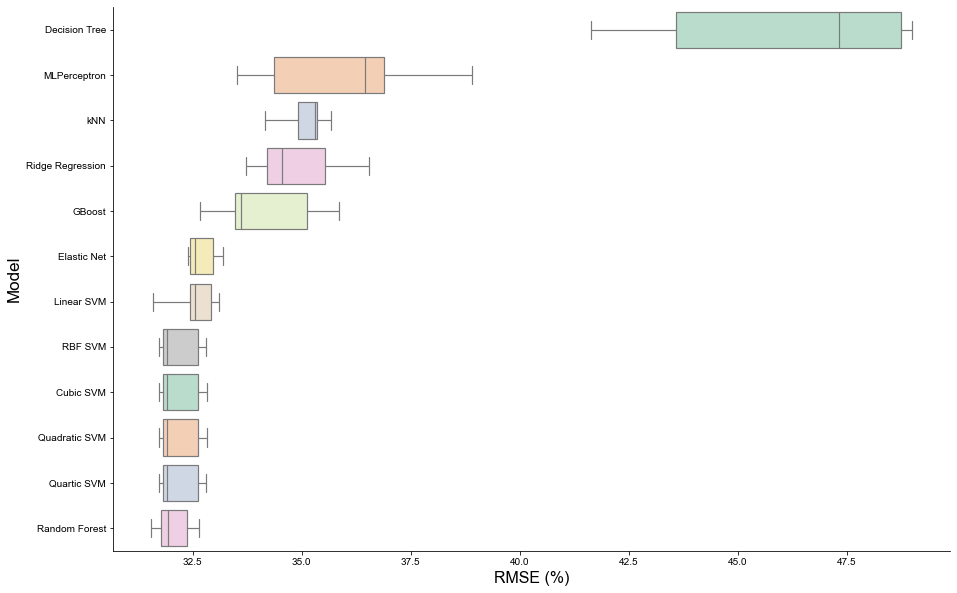

In [19]:

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_style(style='white')
sns.set_context('paper', font_scale=2)
box = sns.boxplot(data=random_rmse_df, orient='h', palette='Pastel2', whis=100, linewidth=1.2)
sns.despine(left=False, bottom=False)
ax.set_xlabel('RMSE (%)', fontsize=16)
ax.set_ylabel('Model', fontsize=17)
#ax.set_title('Model Performance under 5-fold Cross-Validation for Random Features')


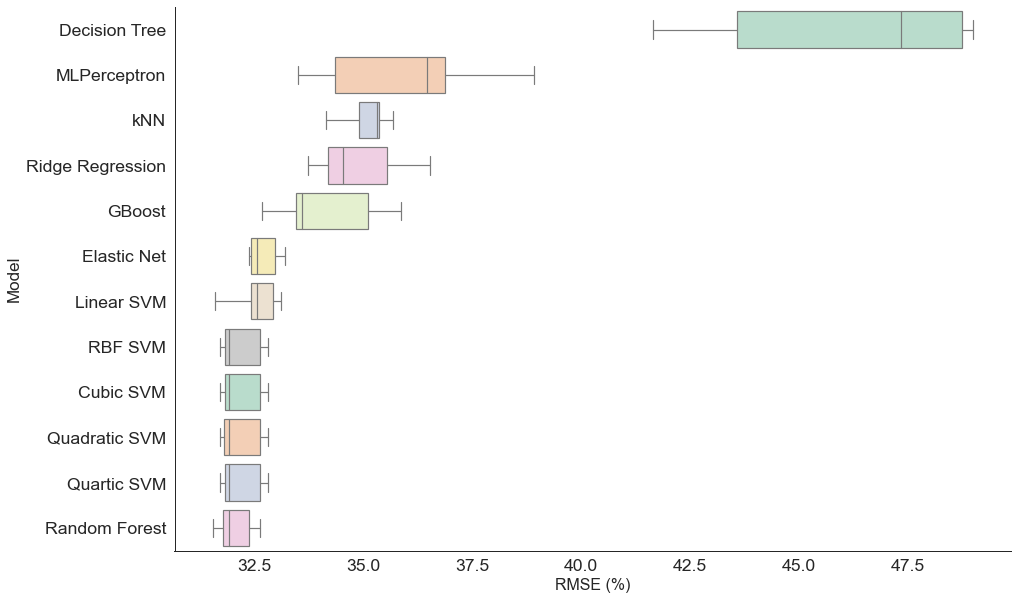

In [40]:
random_box_plot = box_and_whisker(random_rmse, title='Model Performance under 5-fold Cross Validation for Random Features')
random_box_plot
random_box_plot.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/random_rmse.png', bbox_inches='tight', pad_inches=0)

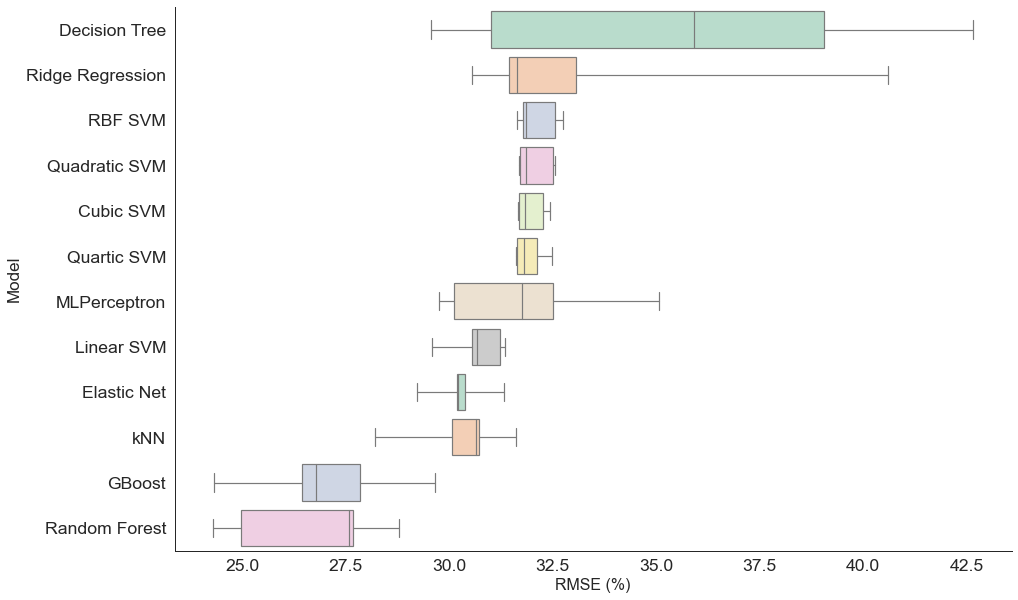

In [39]:
box_and_whisker(dft_rmse, title='Model Performance under 5-fold CV for DFT-derived Features').savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/dft_box.png', bbox_inches='tight', pad_inches=0)

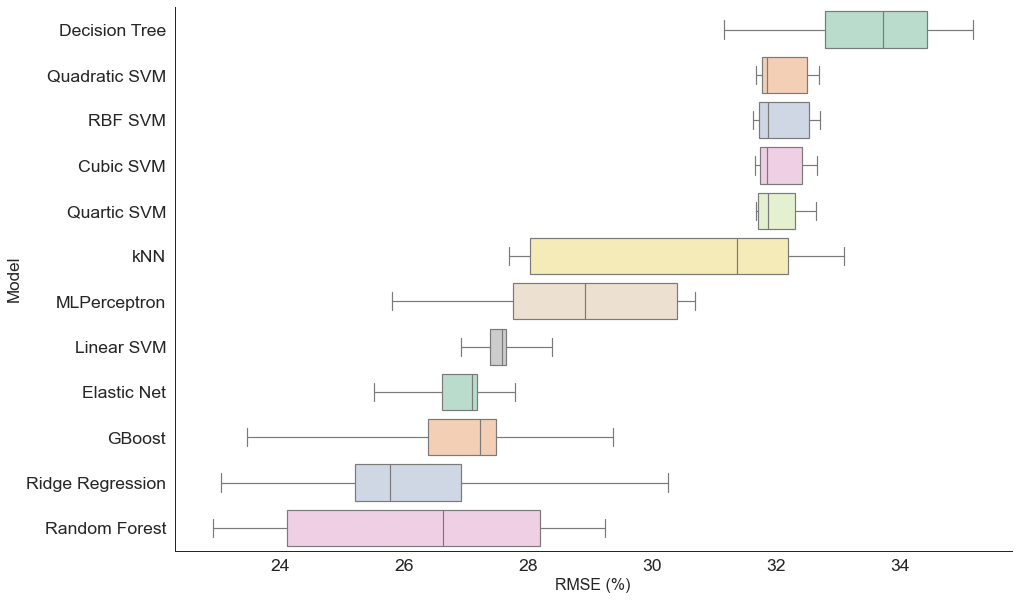

In [41]:
descriptor_box_plot = box_and_whisker(descriptor_rmse, title='Model Performance under 5-fold CV for 2D Descriptor Features', xlims=[20, 100]).savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/2d_descriptor_rmse_box.png', bbox_inches='tight', pad_inches=0)

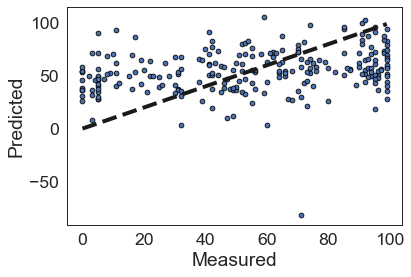

In [24]:
fig, ax = plt.subplots()
ax.scatter(training_labels_unscaled, dft_predicted['Ridge Regression'], edgecolors=(0, 0, 0))
ax.plot([training_labels_unscaled.min(), training_labels_unscaled.max()], [training_labels_unscaled.min(), training_labels_unscaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [43]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets."""
    sns.set_style(style='white')
    sns.set_context('paper')
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured Yield /%', fontsize=14)
    ax.set_ylabel('Predicted Yield /%', fontsize=14)
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left', fontsize=20)
    title = title 
    ax.set_title(title, fontsize=16)

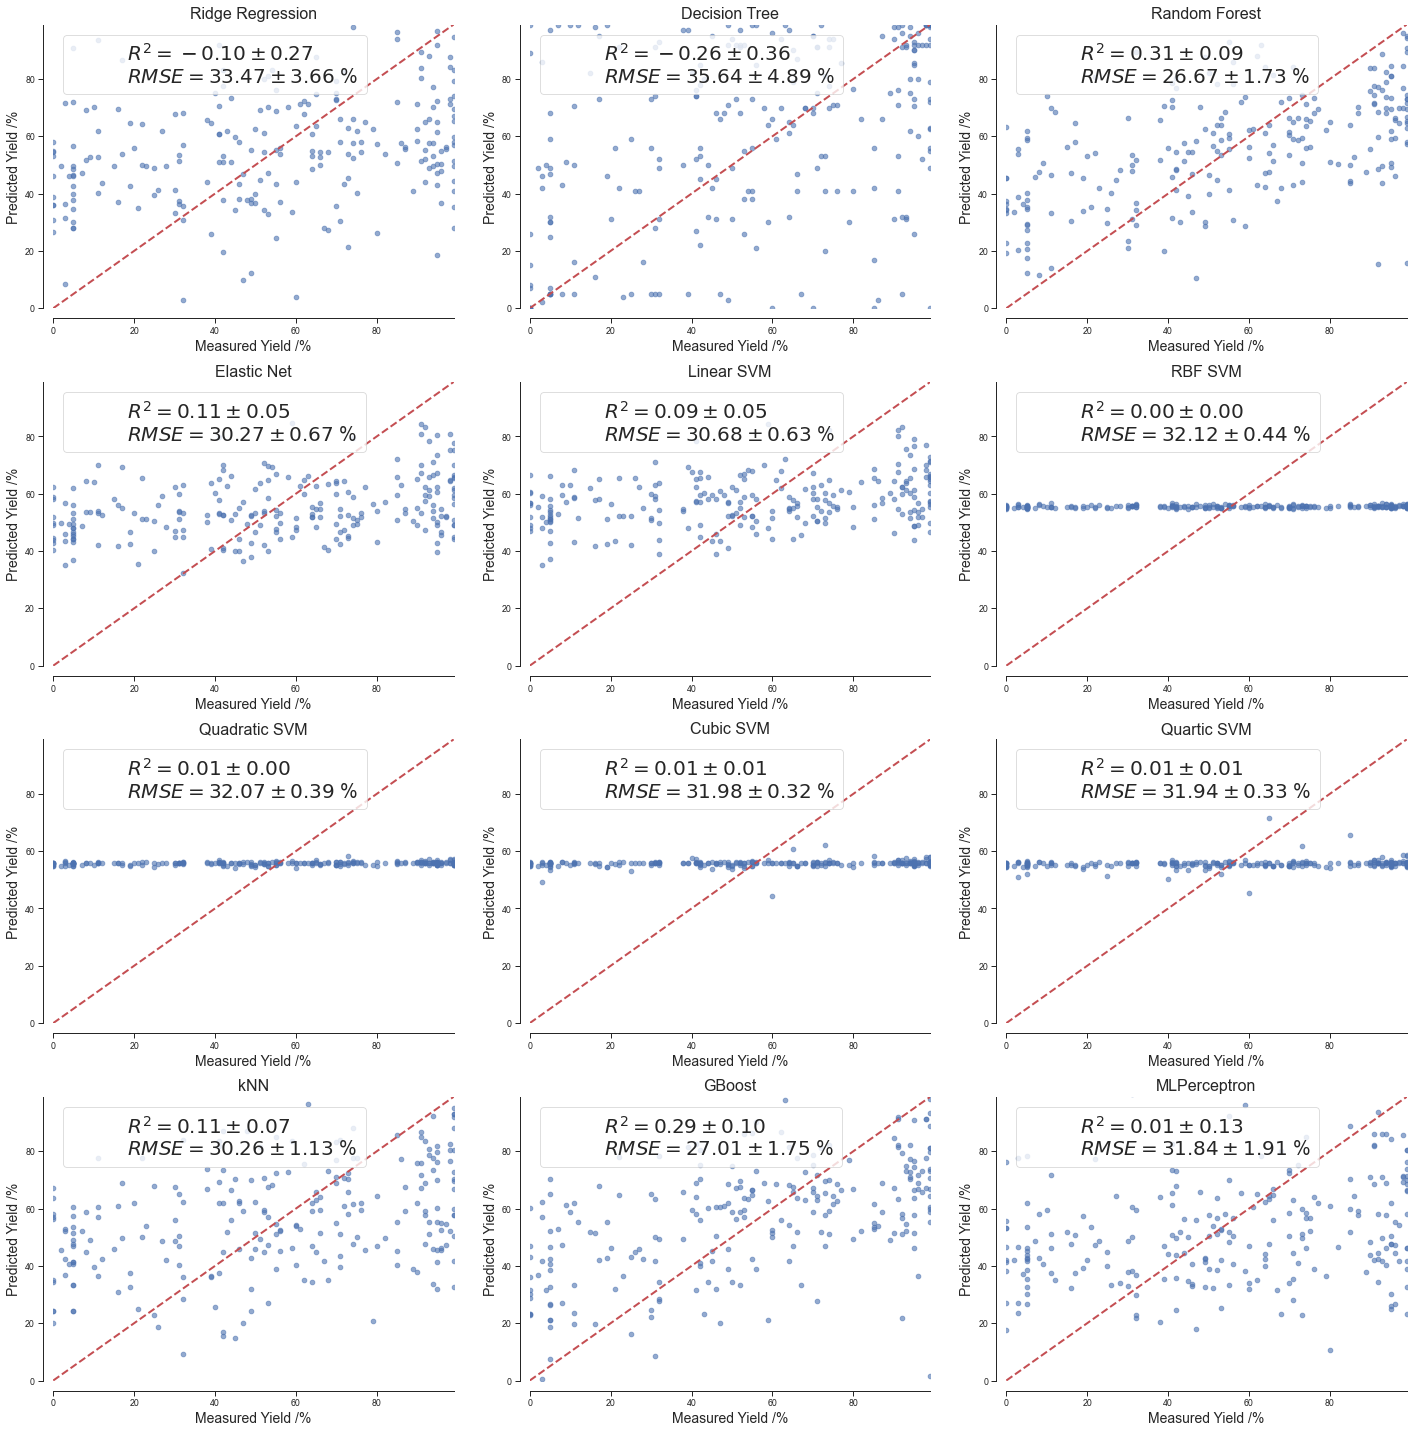

In [44]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for index, (key, value) in enumerate(dft_predicted.items()):
    ax = fig.add_subplot(4, 3, index +1)
    plot_regression_results(ax, training_labels_unscaled, value, key,
    (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$ %')
        .format(np.mean(dft_r2[key]),
                np.std(dft_r2[key]),
                np.mean(dft_rmse[key]),
                np.std(dft_rmse[key])))



#plt.suptitle('Predicted Yield vs Measured Yield for DFT Derived Features', fontsize=22)
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/DFT_predictedvstrue.png')
plt.show()

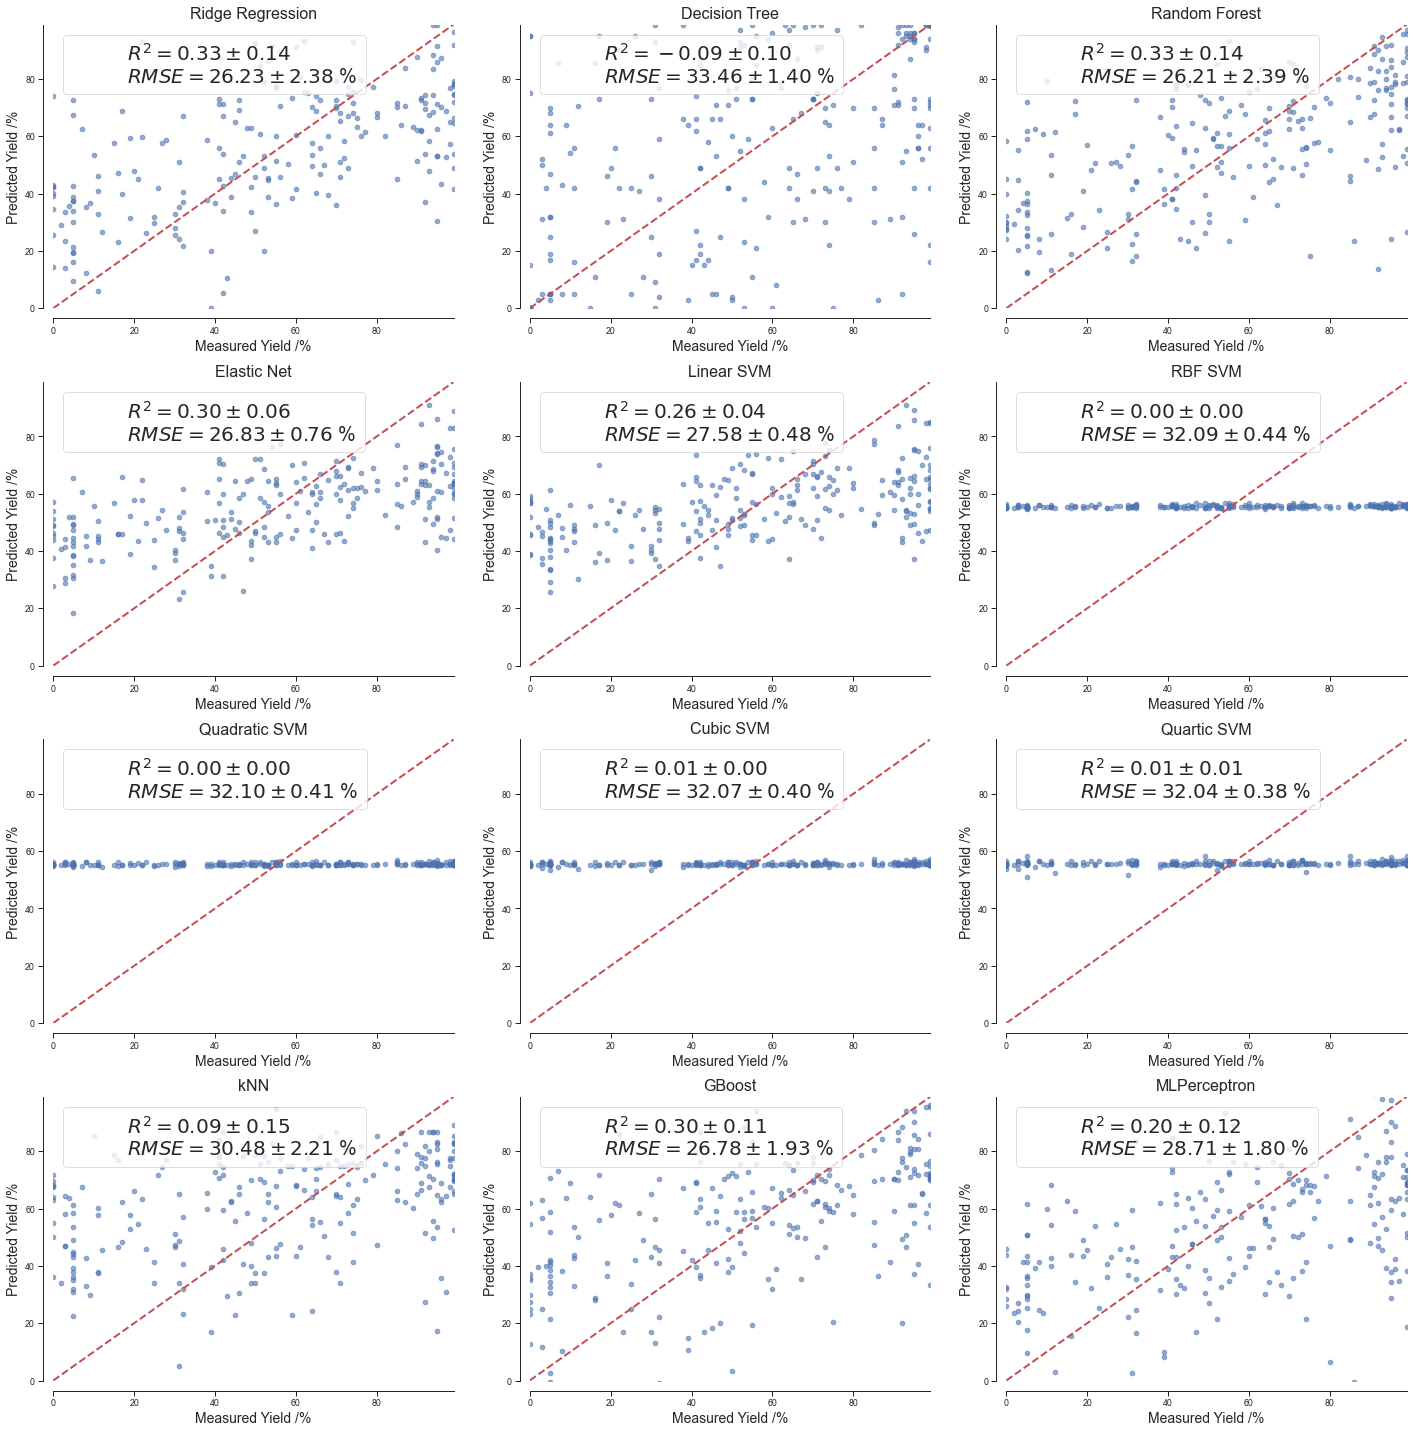

In [50]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for index, (key, value) in enumerate(descriptor_predicted.items()):
    ax = fig.add_subplot(4, 3, index +1)
    plot_regression_results(ax, training_labels_unscaled, value, key,
    (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$ %')
        .format(np.mean(descriptor_r2[key]),
                np.std(descriptor_r2[key]),
                np.mean(descriptor_rmse[key]),
                np.std(descriptor_rmse[key])))



#plt.suptitle('Predicted Yield vs Measured Yield for 2D Descriptor Features', fontsize=22)
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/descriptors_predvstrue.png')
plt.show()

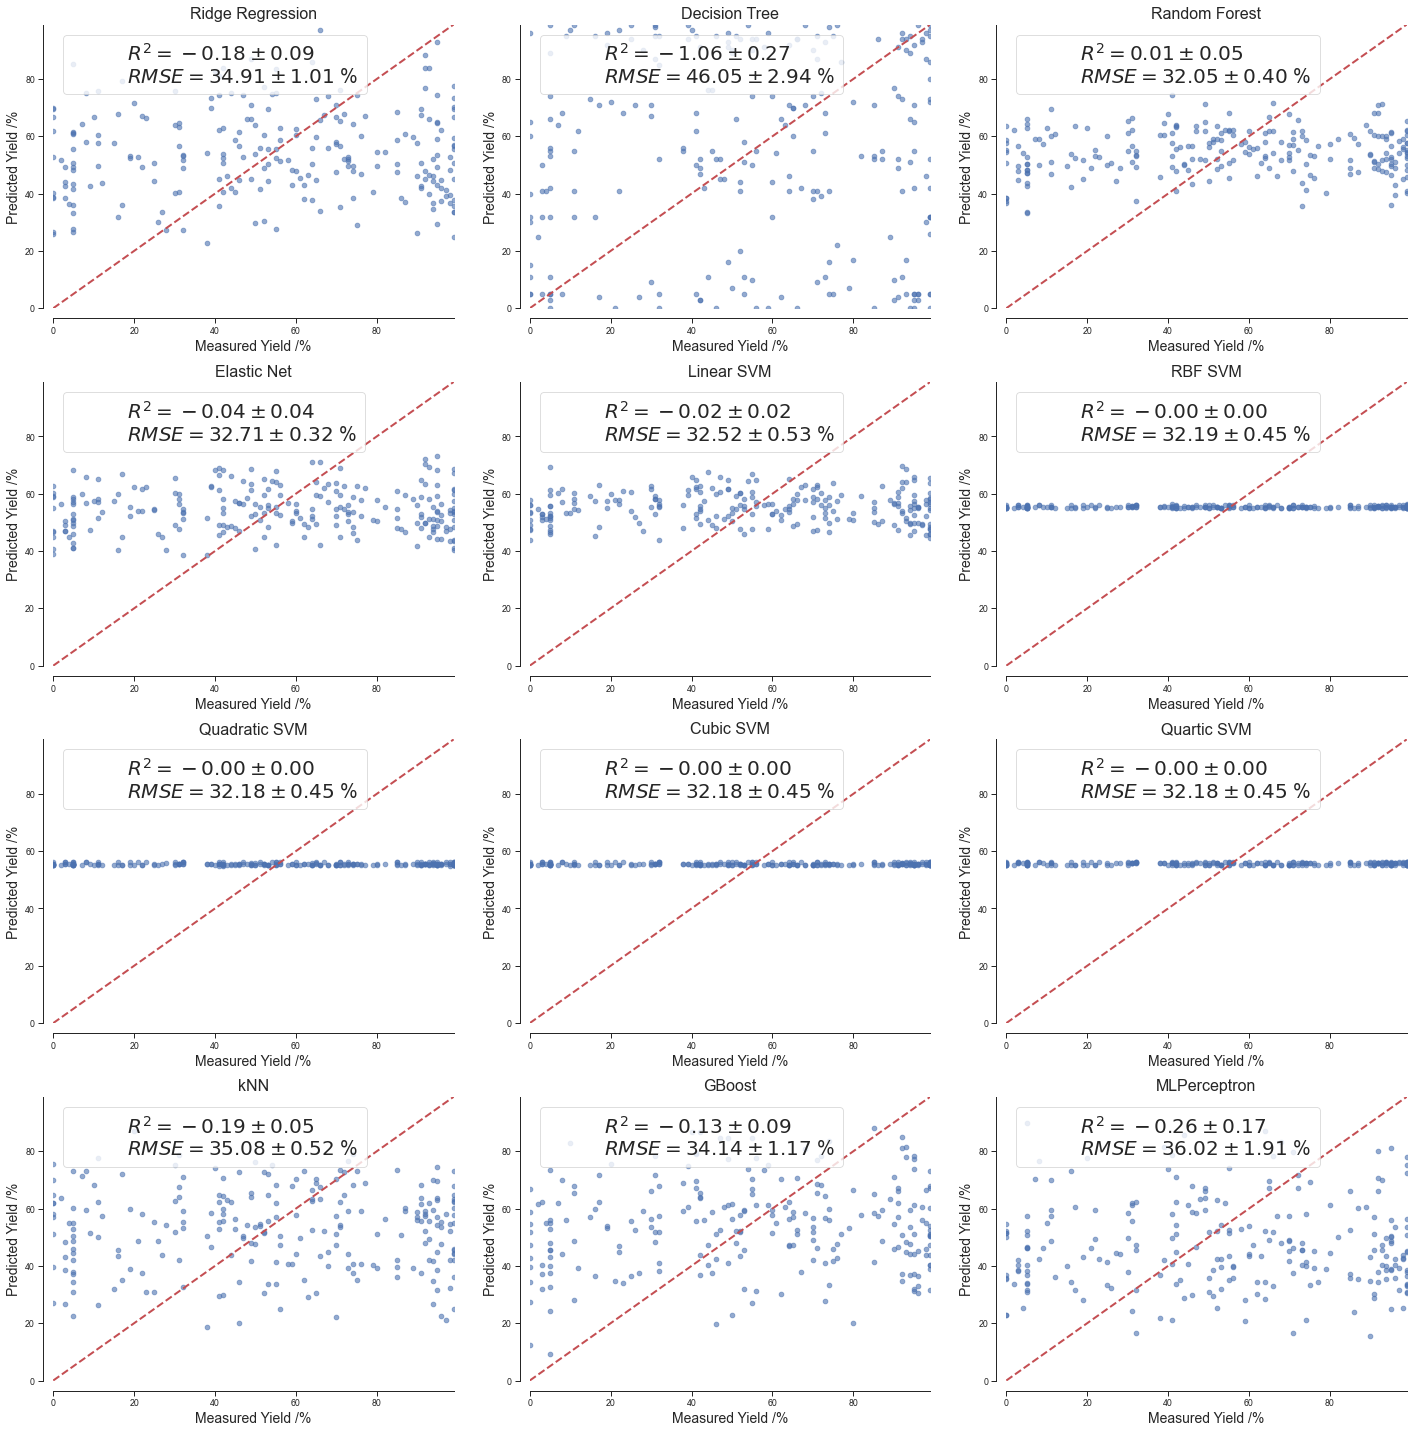

In [46]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for index, (key, value) in enumerate(random_predicted.items()):
    ax = fig.add_subplot(4, 3, index +1)
    plot_regression_results(ax, training_labels_unscaled, value, key,
    (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$ %')
        .format(np.mean(random_r2[key]),
                np.std(random_r2[key]),
                np.mean(random_rmse[key]),
                np.std(random_rmse[key])))



#plt.suptitle('Predicted Yield vs Measured Yield for Random Features', fontsize=22)
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/random_predvstrue.png')
plt.show()

In [ ]:
#Grid search for Random Forest hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': list(range(50, 500, 10)), 'max_features': list(range(5, 50, 10))}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                                scoring =['r2', 'neg_mean_squared_error'], return_train_score=True, refit = 'neg_mean_squared_error')

grid_search.fit(descriptor_features, training_labels_unscaled)

In [183]:
grid_search.best_estimator_

RandomForestRegressor(max_features=15, n_estimators=450)

In [199]:
#Retry Random Forest with new parameters

best_forest_reg = RandomForestRegressor(n_estimators=160, random_state=42)
best_forest_reg.fit(descriptor_features, training_labels_unscaled)
best_forest_scores = cross_validate(best_forest_reg, descriptor_features, training_labels_unscaled, scoring=['r2', 'neg_mean_squared_error'], cv=5)
best_forest_predictor = cross_val_predict(best_forest_reg, descriptor_features, training_labels_unscaled, cv=5)

In [200]:
best_forest_scores

{'fit_time': array([0.61208987, 0.49275708, 0.52835917, 0.86827087, 0.59859896]),
 'score_time': array([0.02611613, 0.02185392, 0.10584593, 0.03144026, 0.02407026]),
 'test_r2': array([0.17424878, 0.5176603 , 0.33890427, 0.46195111, 0.19679259]),
 'test_neg_mean_squared_error': array([-836.21037782, -513.69177826, -672.69129927, -577.02856935,
        -806.64640778])}

<function matplotlib.pyplot.show(close=None, block=None)>

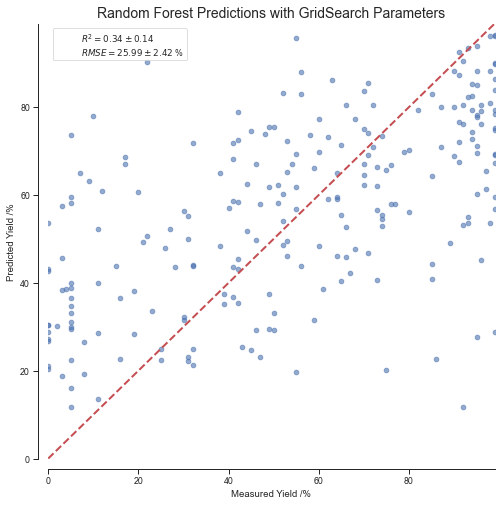

In [201]:
r2_mean = np.mean(best_forest_scores['test_r2'])
r2_std = np.std(best_forest_scores['test_r2'])
rmse_mean = np.mean(np.sqrt(-best_forest_scores['test_neg_mean_squared_error']).tolist())
rmse_std = np.std(np.sqrt(-best_forest_scores['test_neg_mean_squared_error']).tolist())


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
plot_regression_results(ax, training_labels_unscaled, best_forest_predictor, 'Random Forest Predictions with GridSearch Parameters', (f'$R^2={r2_mean:.2f} \pm {r2_std:.2f}$' + '\n' + f'$RMSE={rmse_mean:.2f} \pm {rmse_std:.2f}$ %'))

plt.show

In [135]:
best_forest_scores

{'fit_time': array([0.61338496, 0.47795725, 0.38398314, 0.48199391, 0.90029001]),
 'score_time': array([0.01906514, 0.01952195, 0.01775479, 0.03326201, 0.04116488]),
 'test_r2': array([0.19404469, 0.52955148, 0.3372267 , 0.48078121, 0.19114776]),
 'test_neg_mean_squared_error': array([-816.16372732, -501.02767153, -674.39829916, -556.83429661,
        -812.3153992 ])}